# Identication of putative contaminant taxa

In [1]:
setwd("/mnt/c/Users/Cedric/Desktop/git_repos/blood_microbiome")
require(foreach)
require(tidyverse)
require(ggplot2)
require(data.table)
require(compositions)
require(doParallel)
registerDoParallel(cores=8)

Loading required package: foreach

Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ purrr::when()       masks foreach::when()

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: compos

### Data pre-processing functions

In [2]:
load_data <- function(file_path) {
    df <- as.data.frame(fread(file_path)) %>%
        separate(sample, into = c(NA, "npm_research_id"), sep = "\\.")
    return(df)
}


load_metadata <- function(file_path, df) {
    meta <- fread(file_path, na.strings=c("", NA))
    meta <- meta %>% 
        filter(npm_research_id %in% df$npm_research_id) %>%
        select(-removal_requested_by_supplier) %>%
        replace(is.na(.), "unknown")
    return(meta)
}


subset_metadata <- function(meta, n_subset) {
    meta <- as.data.frame(meta)
    cohorts <- unique(meta$site_supplying_sample)
    subset_vec <- c()

    for (i in cohorts) {
        ids <- meta$npm_research_id[meta$site_supplying_sample == i]
        
        if (length(ids) > n_subset) {
            subset_ids <- sample(ids, n_subset)
            subset_vec <- c(subset_vec, subset_ids)
        } else {
            subset_vec <- c(subset_vec, ids)
        }
    }

    meta_sub <- meta %>%
      filter(npm_research_id %in% subset_vec) 
    return(meta_sub)
}


retrieve_rows_from_meta <- function(df, meta) {
    return(df %>% filter(npm_research_id %in% meta$npm_research_id)) 
}


remove_cols <- function(df, col_to_exclude) {
    return(df %>% select(-all_of(col_to_exclude)))
}


remove_low_prev_taxa <- function(df, frac_presence, read_threshold) {
    n_original <- ncol(df[, colnames(df) != "npm_research_id"])
    PA_df <- apply(df[, 2:ncol(df)], 2, function(x) {ifelse(x > read_threshold, T, F)})
    frac_df <- apply(PA_df, 2, function(x) {sum(x) / nrow(PA_df)})
    to_keep <- names(frac_df[frac_df > frac_presence])
    to_keep <- c("npm_research_id", to_keep)
    n_new <- length(to_keep) - 1
    print(str_glue("{n_new} / {n_original} taxa are present in {frac_presence} of samples"))
    return(df %>% select(all_of(to_keep)))
}


otu_to_RA <- function(df) {
    mat <- as.matrix(df[, colnames(df) != "npm_research_id"])
    RA_df <- as.data.frame(mat / rowSums(mat))
    RA_df <- add_column(RA_df, df$npm_research_id, .before = 1)
    colnames(RA_df)[1] <- "npm_research_id"
    
    return(RA_df)
}


RA_to_clr <- function(df) {
    mat <- df_filt[, colnames(df_filt) != "npm_research_id"]
    clr_df <- clr(mat)
    return(cbind(data.frame(npm_research_id = df$npm_research_id), as.data.frame(clr_df, check.names = F)))
}


get_metadata_plots <- function(meta, meta_cols) {
    meta <- as.matrix(meta)
    meta <- as_tibble(meta, rownames = "sample")

    plots <- list()
    
    for (column in meta_cols) {
        plt <- meta %>%
            mutate(across(everything(), as.character)) %>%
            select(all_of(column)) %>%
            group_by_at(column) %>%
            summarise(n = n()) %>%
            ggplot(aes_string(x = column, y = "n", fill = column)) +
                geom_bar(stat = "identity") +
                theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
                geom_text(aes_string(label = "n"))
        plots[[column]] <- plt
    }
    
    return(plots)
}


get_meta_cols <- function(meta) {
    meta_cols <- colnames(meta)[grep("kit|flow_cell|instrument_id|site_supplying", colnames(meta))]
    to_exclude <- c("library_prep_kit", "hiseq_xtm_flow_cell_v2_5_id")
    meta_cols <- meta_cols[!(meta_cols %in% to_exclude)]
    return(meta_cols)
}


print_group_freqs <- function(meta, meta_cols) {
    for (col in meta_cols) {
        tmp <- tibble(data.frame(meta)) %>%
            group_by(get(col)) %>%
            summarise(n = n())
        print(col)
        print(tmp)
    }
}


get_batch_prevalence <- function(x) {sum(x) / length(x)}


remove_low_read_samples <- function(df) {
    to_retain <- fread("data/samples_above_10_reads.txt")$npm_research_id
    return(df %>% filter(npm_research_id %in% to_retain))
}


remove_low_sample_levels <- function(dat, metadat, column, min_samples) {
    # Remove levels with < x samples
    tmp <- tibble(data.frame(metadat)) %>%
            group_by(get(column)) %>%
            summarise(n = n())

    # Vector of group levels to keep
    to_keep <- tmp[tmp$n >= min_samples, "get(column)"]$`get(column)`
    to_keep <- to_keep[to_keep != "Unknown"]
    n_levels <- length(to_keep)

    if (n_levels < 2) {
        print(str_glue("After pruning, {column} has < 2 levels"))
    } else {
        print(str_glue("After pruning, {column} has {n_levels} levels"))
    }

    # Remove rows in metadata
    metadat_filt <- metadat %>% filter(get(column) %in% to_keep)

    # Retrieve rows
    dat_filt <- retrieve_rows_from_meta(dat, metadat_filt)
    metadat_filt <- metadat_filt %>% filter(npm_research_id %in% dat_filt$npm_research_id)

    return(list(dat_filt = dat_filt, metadat_filt = metadat_filt))
}


remove_empty_rows <- function(df) {
    mat <- as.matrix(df[, colnames(df) != "npm_research_id"])
    row_sums <- rowSums(mat)
    df_filt <- df[row_sums != 0, ]
    nrow(df_filt)

    n_original <- nrow(df)
    n_removed <- n_original - nrow(df_filt)
    
    print(str_glue("{n_removed}/{n_original} samples removed due to having no reads of interest"))
    
    return(df_filt)
}

#### Functions for testing differential abundance

In [3]:
get_diff_abn <- function(dat_filt, metadat_filt, taxon, column, lq_p = 0.25, hq_p = 0.75, min_samples, fold_threshold = 0) {
    # Remove zeros in CLR values
    q_df <- dat_filt %>%
        left_join(metadat_filt, by = "npm_research_id") %>%
        select(all_of(c(taxon, column))) %>%
        filter(get(taxon) != 0) %>%
        group_by(get(column)) %>%
        summarise(lq = quantile(get(taxon), probs = lq_p),
                  hq = quantile(get(taxon), probs = hq_p),
                  n_samples = n()) %>%
    filter(n_samples > min_samples)  # Remove levels that have less than {min_samples} no. of non-zero samples
    
    # Analyse only if there are more than two valid levels for analysis
    if (nrow(q_df) >= 2) {
        # Do pairwise comparisons between levels
        pairwise_results <- foreach(idx = seq(nrow(q_df))) %do% {
            level1 <- q_df[idx, ]
            level1_name <- level1$`get(column)`
            lowest_lq <- level1$lq
            level1_n_samples <- level1$n_samples
            
            diff_df <- q_df %>% 
                mutate(diff_abn = ifelse(hq + fold_threshold < lowest_lq, 1, 0)) %>%
                rename("level2" = "get(column)")

#             if(any(diff_df$diff_abn == 1)) {
            res <- diff_df %>%
#                     filter(diff_abn == 1) %>%
                mutate(taxa = taxon, meta_col = column, level1 = level1_name, .before = 1) %>%
                mutate(level1_n_samples = level1_n_samples, .before = 7) %>%
#                     select(-diff_abn) %>% 
                rename(level1_lq = lq, level2_hq = hq, level2_n_samples = n_samples)

            return(res)
#             }
        }
        
        return(bind_rows(pairwise_results))  # Return only comparisons which show differential abundance
        
    } else {
        return(tibble(taxa = taxon, meta_col = column, 
                      level1 = NA, level2 = NA, level1_lq = NA, level2_hq = NA, 
                      level1_n_samples = NA, level2_n_samples = NA, diff_abn = NA))
    }
}


decontaminate_this_col <- function(dat, metadat, column, min_samples, lq_p, hq_p, fold_threshold) {
    data_list <- remove_low_sample_levels(dat, metadat, column, min_samples)
    metadat_filt <- data_list[["metadat_filt"]]
    dat_filt <- data_list[["dat_filt"]]
    taxa <- colnames(dat_filt %>% select(-npm_research_id))
    
    # Get differential abundance results for all taxa
    col_results <- foreach(taxon = taxa) %dopar% {
        taxon_results <- get_diff_abn(dat_filt, metadat_filt, taxon, column, 
                                      lq_p = lq_p, hq_p = hq_p, 
                                      min_samples = min_samples, 
                                      fold_threshold = fold_threshold)
    }

    return(bind_rows(col_results))
}

decontaminate_all_cols <- function(df_filt, meta_filt, meta_cols, min_samples, lq_p, hq_p, fold_threshold) {
    results <- foreach(column = meta_cols) %do% {
        col_res <- decontaminate_this_col(df_filt, meta_filt, column, 
                                          min_samples = min_samples, 
                                          lq_p = lq_p, 
                                          hq_p = hq_p, 
                                          fold_threshold = fold_threshold)
        return(col_res)
    }
    
    return(bind_rows(results))
}


parse_results <- function(result_df, meta_cols) {
    parsed_df <- result_df %>% 
        group_by(taxa, meta_col) %>%
        summarise(n_na = sum(is.na(diff_abn)),
                  n_diff = ifelse(sum(diff_abn, na.rm = T) > 0, 1, 0)) %>%
        group_by(taxa) %>%
        summarise(n_na = sum(n_na), n_diff = sum(n_diff))

    nc <- parsed_df %>% filter(n_na < length(meta_cols), n_diff == 0) %>% select(taxa)
    contams <- parsed_df %>% filter(n_na < length(meta_cols), n_diff != 0) %>% select(taxa)
    unknowns <- parsed_df %>% filter(n_na == length(meta_cols)) %>% select(taxa)
    
    return(list(non_contaminants = nc, contaminants = contams, unknowns = unknowns))
}

## Main

#### Params

In [4]:
min_samples <- 10
n_subset <- 9999
human <- "Homo sapiens"
rank <- "S"
n <- 9999
frac_presence <- 0
lq_p <- 0.10
hq_p <- 0.90
fold_threshold <- 0
read_threshold <- 10

#### Load and parse data

In [5]:
to_retain <- fread("data/samples_above_95_reads.txt")$npm_research_id
df <- load_data(str_glue("data/temp_files_{n_subset}/07_abundance_matrix/abundance_matrix.subset_{n_subset}.{rank}.tsv")) %>% 
    filter(npm_research_id %in% to_retain)
meta <- load_metadata("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv", df)

# Get metadata subset
meta_filt <- subset_metadata(meta, n)

# Filter data
df_filt <- retrieve_rows_from_meta(df, meta_filt)
df_filt <- remove_cols(df_filt, c(human, "unclassified"))
df_filt <- remove_low_prev_taxa(df_filt, frac_presence = frac_presence, read_threshold = 10)
df_filt <- otu_to_RA(df_filt)
df_filt <- RA_to_clr(df_filt)

# Get metadata columns of interest
meta_cols <- get_meta_cols(meta_filt)

2183 / 5199 taxa are present in 0 of samples


#### Run decontamination

In [15]:
# Run decontamination
system.time(result_df <- decontaminate_all_cols(df_filt, meta_filt, meta_cols, min_samples, lq_p, hq_p, fold_threshold))
head(result_df)

After pruning, site_supplying_sample has 6 levels
After pruning, extraction_kit has 6 levels
After pruning, instrument_id has 5 levels
After pruning, hiseq_xtm_sbs_kit_300_cycles_v2__box_1of_2__lot has 33 levels
After pruning, hiseq_xtm_sbs_kit_300_cycles_v2__box_2_of_2__lot has 30 levels
After pruning, hiseq_xtm_pe_cluster_kit_cbottm_v2__box_1_of_2__lot has 27 levels
After pruning, hiseq_xtm_pe_cluster_kit_cbottm_v2__box_2_of_2__lot has 30 levels
After pruning, hiseq_xtm_flow_cell_v2_5_lot has 34 levels


    user   system  elapsed 
6294.672  206.907  835.888 

taxa,meta_col,level1,level2,level1_lq,level2_hq,level1_n_samples,level2_n_samples,diff_abn
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>
Paraburkholderia fungorum,site_supplying_sample,GUSTO,GUSTO,-0.8759667,0.3737458,97,97,0
Paraburkholderia fungorum,site_supplying_sample,GUSTO,HELIOS,-1.0322213,0.1751339,97,756,0
Paraburkholderia fungorum,site_supplying_sample,GUSTO,MEC,-1.2934842,2.3950029,97,1074,0
Paraburkholderia fungorum,site_supplying_sample,GUSTO,PRISM,-1.7155051,1.4935845,97,956,0
Paraburkholderia fungorum,site_supplying_sample,GUSTO,SERI,-0.3722952,3.3452331,97,663,0
Paraburkholderia fungorum,site_supplying_sample,GUSTO,TTSH,-0.6115676,5.3671477,97,297,0


### Parse results

In [16]:
parsed_res <- parse_results(result_df, meta_cols)

fwrite(parsed_res[["non_contaminants"]], str_glue("results/decontamination/clr_decontamination/nc.n9999.min_samples{min_samples}.l{lq_p * 100}h{hq_p * 100}.txt"))
fwrite(parsed_res[["contaminants"]], str_glue("results/decontamination/clr_decontamination/contams.n9999.min_samples{min_samples}.l{lq_p * 100}h{hq_p * 100}.txt"))
fwrite(parsed_res[["unknowns"]], str_glue("results/decontamination/clr_decontamination/unknowns.n9999.min_samples{min_samples}.l{lq_p * 100}h{hq_p * 100}.txt"))
fwrite(result_df, str_glue("results/decontamination/clr_decontamination/raw_results.n9999.min_samples{min_samples}.l{lq_p * 100}h{hq_p * 100}.csv"))

`summarise()` has grouped output by 'taxa'. You can override using the `.groups` argument.



In [17]:
all_species <- colnames(df %>% select(-npm_research_id, -"Homo sapiens", -"unclassified"))
initial <- length(all_species)
non_zero <- length(df_filt) - 1
after_diff <- nrow(parsed_res[["non_contaminants"]])
n_unknowns <- nrow(parsed_res[["unknowns"]])

print(str_glue("Initial no. of species = {initial}"))
print(str_glue("Species present in at least one sample (reads > {read_threshold}) = {non_zero}"))
print(str_glue("After differential abundance filter (min_samples = {min_samples}) = {after_diff}"))
print(str_glue("Species that could not be analysed = {n_unknowns}"))

Initial no. of species = 5199
Species present in at least one sample (reads > 10) = 2183
After differential abundance filter (min_samples = 10) = 387
Species that could not be analysed = 141


In [9]:
afwfdwdawad

ERROR: Error in eval(expr, envir, enclos): object 'afwfdwdawad' not found


### Correlation filter after Diff. Prev. + Diff. Abn.

In [20]:
min_samples <- 10
lq_p <- 0.15
hq_p <- 0.85

diff_abn_nc <- read.csv(str_glue("results/decontamination/clr_decontamination/nc.n9999.min_samples{min_samples}.l{lq_p * 100}h{hq_p * 100}.txt"))$taxa
diff_abn_contam <- read.csv(str_glue("results/decontamination/clr_decontamination/contams.n9999.min_samples{min_samples}.l{lq_p * 100}h{hq_p * 100}.txt"))$taxa
diff_prev_nc <- read.csv("results/decontamination/diff_prev_V2/noncontam.min_samples100.raw.read_t10.S.n9999.txt")$non_contaminants

nc <- intersect(diff_abn_nc, diff_prev_nc)

In [23]:
corr_decontam <- function(df, non_contaminants, contaminants) {
    nc_list <- foreach (non_contaminant_taxon = non_contaminants) %dopar% {
        morsel <- tibble()
        for (contaminant_taxon in contaminants) {
            spearman_test <- cor.test(df[ ,contaminant_taxon], df[, non_contaminant_taxon])
            rho <- spearman_test$estimate
            print(str_glue("{non_contaminant_taxon} has correlation of {rho} with {contaminant_taxon}"))
            morsel <- morsel %>% bind_rows(tibble(non_contaminant_taxon = non_contaminant_taxon, 
                                           contaminant_taxon = contaminant_taxon,
                                           rho = rho))
        }

        return(morsel)
    }

    corr_df <- bind_rows(nc_list)  
    return(corr_df)
}


parse_corr_results <- function(corr_df, nc, corr_t) {
    contaminants <- corr_df %>% 
        filter(rho > corr_t) %>%
        distinct(non_contaminant_taxon) %>%
        rename(contaminants = non_contaminant_taxon)
    
    non_contaminants <- tibble(non_contaminants = nc) %>% 
        filter(!(non_contaminants %in% contaminants$contaminants))
    
    return(list(non_contaminants = non_contaminants, contaminants = contaminants))
}

In [59]:
corr_res <- corr_decontam(df_filt, nc, diff_abn_contam)

non_contaminants
<chr>
contaminants
<chr>
Acidaminococcus intestini
Acinetobacter equi
Acinetobacter lactucae
Acinetobacter oleivorans
Acinetobacter sp. WCHAc010052
Actinoplanes friuliensis
Aerococcus christensenii


In [207]:
corr_res %>%
    group_by(non_contaminant_taxon) %>%
    mutate(above_corr = ifelse(rho > 0.1, T, F)) %>%
    summarise(diff = sum(above_corr) - sum(!(above_corr)))

non_contaminant_taxon,diff
<chr>,<int>
Acidaminococcus intestini,-1832
Acinetobacter equi,-1824
Acinetobacter lactucae,-1850
Acinetobacter oleivorans,-1840
Acinetobacter sp. WCHAc010052,-1832
Actinoplanes friuliensis,46
Aerococcus christensenii,-1848
Aggregatibacter segnis,-1734
Alloactinosynnema sp. L-07,130


In [217]:
parse_corr_results <- function(corr_df, nc, corr_t) {
    parsed <- corr_res %>%
        group_by(non_contaminant_taxon) %>%
        mutate(above_corr = ifelse(rho > corr_t, T, F)) %>%
        summarise(diff = sum(above_corr) - sum(!(above_corr)))
    
    contaminants <- parsed %>%
        filter(diff >= 0) %>%
        distinct(non_contaminant_taxon) %>%
        rename(contaminants = non_contaminant_taxon)
    
    non_contaminants <- parsed %>%
        filter(diff < 0) %>%
        distinct(non_contaminant_taxon)
    
    return(list(non_contaminants = non_contaminants, contaminants = contaminants))
}

In [220]:
corr_parsed <- parse_corr_results(corr_res, nc, corr_t = 0.1)
corr_nc <- corr_parsed[["non_contaminants"]]
corr_c <- corr_parsed[["contaminants"]]

fwrite(corr_nc, 
       str_glue("results/decontamination/correlation_decontamination/nc.diff_prev.diff_abn.l{lq_p * 100}h{hq_p * 100}.corr_t{corr_t}.S.n9999.txt"))
fwrite(corr_c, 
       str_glue("results/decontamination/correlation_decontamination/contam.diff_prev.diff_abn.l{lq_p * 100}h{hq_p * 100}.corr_t{corr_t}.S.n9999.txt"))

print(length(corr_nc$non_contaminant_taxon))
print(length(corr_c$contaminants))

[1] 156
[1] 28


### Choosing  correlation threshold

#### Heatmap of correlations

In [216]:
hm_df <- corr_res %>%
    mutate(fill_color = case_when(rho <= 0 ~ "<0",
                     rho > 0 & rho <= 0.1 ~ "0-10",
                     rho > 0.1 & rho <= 0.2 ~ "10-20",
                     rho > 0.2 & rho <= 0.3 ~ "20-30",
                     rho > 0.3 ~  ">30")) %>%
    mutate(fill_color = factor(fill_color, levels = c("<0", "0-10", "10-20", "20-30", ">30")))

wide_df <- hm_df %>%
    pivot_wider(!fill_color, names_from = non_contaminant_taxon, values_from = rho) %>%
    column_to_rownames("contaminant_taxon")

data <- scale(t(wide_df))
ord_row <- hclust(dist(data, method = "euclidean"), method = "ward.D")$order

data <- scale(wide_df)
ord_col <- hclust(dist(data, method = "euclidean"), method = "ward.D")$order

hm <- corr_res %>%
    mutate(fill_color = case_when(rho <= 0 ~ "<0",
                     rho > 0 & rho <= 0.1 ~ "0-10",
                     rho > 0.1 & rho <= 0.2 ~ "10-20",
                     rho > 0.2 & rho <= 0.3 ~ "20-30",
                     rho > 0.3 ~  ">30")) %>%
    mutate(fill_color = factor(fill_color, levels = c("<0", "0-10", "10-20", "20-30", ">30")),
           non_contaminant_taxon = factor(non_contaminant_taxon, levels = colnames(wide_df)[ord_row]), 
           contaminant_taxon = factor(contaminant_taxon, levels = rownames(wide_df)[ord_col])) %>%
    ggplot(aes(x = non_contaminant_taxon, y = contaminant_taxon, fill = fill_color)) +
    geom_tile() +
    theme(axis.ticks.x = element_blank(),
          axis.text.x = element_blank(),
          axis.ticks.y = element_blank(),
          axis.text.y = element_blank()) +
    scale_fill_manual(values = c("#6699cc", "#ffffcc", "#f39b7fb2", "#e64b35b2", "#d11141")) +
    labs(x = "Non-contaminant species", y = "Contaminant species", fill = "Rho (%)")

hm

ggsave(str_glue("results/decontamination/correlation_decontamination/correlation_heatmap.min_samples{min_samples}.l{lq_p * 100}h{hq_p * 100}.png"), dpi = 300)

Saving 6.67 x 6.67 in image



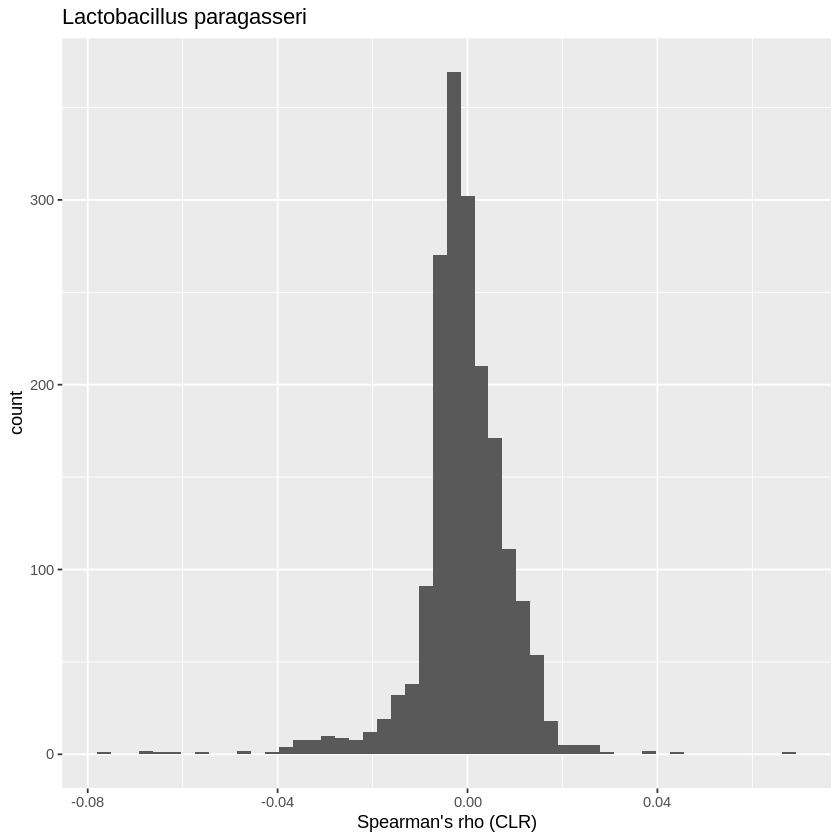

In [211]:
taxon <- "Lactobacillus paragasseri"
taxon_name <- gsub(" ", "_", taxon)
corr_res %>% 
filter(non_contaminant_taxon == taxon) %>%
    ggplot(aes(x = rho)) +
    geom_histogram(bins = 50) +
    labs(x = "Spearman's rho (CLR)", "No. of contaminants", title = taxon)

ggsave(str_glue("results/decontamination/correlation_decontamination/{taxon_name}.min_samples{min_samples}.l{lq_p * 100}h{hq_p * 100}.png"))

Saving 6.67 x 6.67 in image



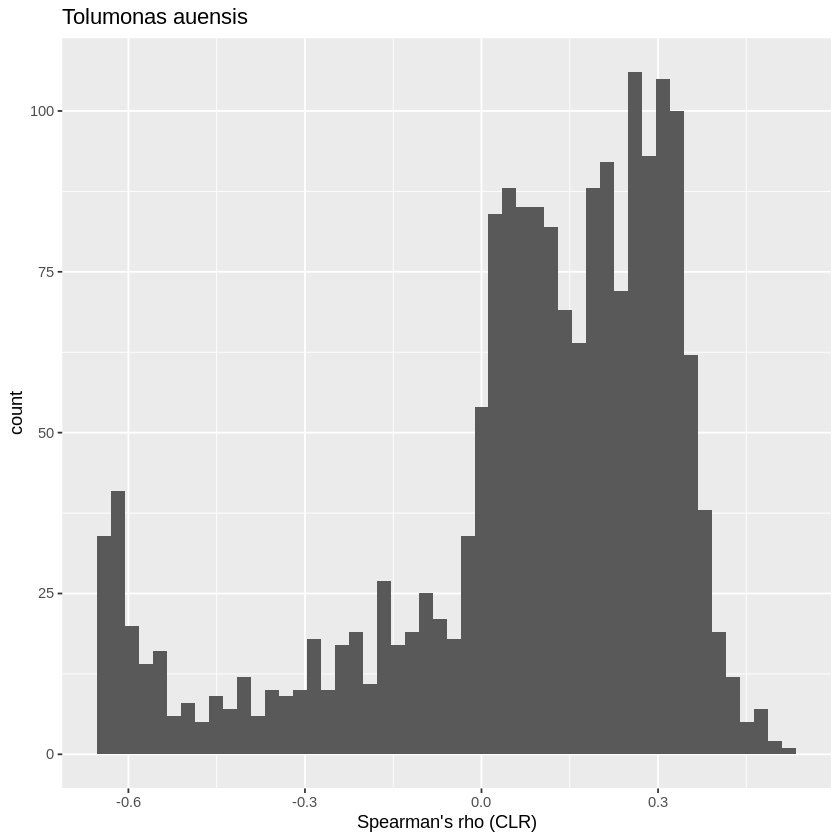

In [215]:
taxon <- "Tolumonas auensis"
taxon_name <- gsub(" ", "_", taxon)
corr_res %>% 
filter(non_contaminant_taxon == taxon) %>%
    ggplot(aes(x = rho)) +
    geom_histogram(bins = 50) +
    labs(x = "Spearman's rho (CLR)", "No. of contaminants", title = taxon)

ggsave(str_glue("results/decontamination/correlation_decontamination/{taxon_name}.min_samples{min_samples}.l{lq_p * 100}h{hq_p * 100}.png"))

### Run decontamination for multiple thresholds

In [ ]:
# params <- foreach (m = c(50, 100), .combine = 'c') %do% {
#     foreach (hq = seq(0.70, 1, 0.01)) %do% {
#         lq <- 1 - hq
#         return(c(m, lq, hq))
#     }
# }

In [ ]:
# all_species <- colnames(df_filt)[colnames(df_filt) != "npm_research_id"]

# threshold_results <- foreach (param = params) %do% {
#     min_samples <- param[1]
#     lq_p <- param[2]
#     hq_p <- param[3]
    
#     # Run decontamination
#     result_df <- decontaminate_all_cols(df_filt, meta_filt, meta_cols, min_samples, lq_p, hq_p, fold_threshold)
    
#     # Parse results
#     non_contaminants <- all_species[!(all_species %in% unique(result_df$taxa))]
#     n_noncontam <- length(non_contaminants)
#     nc_text <- paste0(non_contaminants, collapse = ";")
#     nc_df <- tibble(non_contaminants = non_contaminants)
    
#     fwrite(nc_df, str_glue("results/decontamination/clr_decontamination/NC.n9999.min_samples{min_samples}.l{lq_p * 100}h{hq_p * 100}.txt"), quote = F)
#     fwrite(result_df, str_glue("results/decontamination/clr_decontamination/results.n9999.min_samples{min_samples}.l{lq_p * 100}h{hq_p * 100}.csv"))

#     # Save summary
#     morsel <- tibble(min_samples = min_samples, 
#                   lq_p = lq_p, 
#                   hq_p = hq_p, 
#                   n_noncontam = n_noncontam, 
#                   non_contaminants = nc_text)
#     print(morsel)
    
#     return(morsel)
# }

# threshold_df <- bind_rows(threshold_results)
# fwrite("results/decontamination/clr_decontamination/multiple_threshold_results.csv", threshold_df)

In [ ]:
# fwrite(threshold_df, "results/decontamination/clr_decontamination/multiple_threshold_results.csv")

In [ ]:
# dat_filt %>% 
#     left_join(metadat_filt) %>%
#     filter(get(tax) != 0) %>%
#     group_by(site_supplying_sample) %>%
#     summarise(lq = quantile(get(tax), 0.25), hq = quantile(get(tax), 0.75))

In [ ]:
# dat_filt %>% 
#     pivot_longer(!npm_research_id, names_to = "taxa", values_to = "clr") %>%
#     filter(clr != 0) %>%
#     ggplot(aes(x = clr)) +
#         geom_density()

In [ ]:
# tax <- "Burkholderia stabilis"
# df_filt %>% 
#     left_join(meta_filt) %>%
#     filter(get(tax) != 0) %>%
#     ggplot(aes(y = get(tax), x = site_supplying_sample)) +
#         geom_boxplot()

In [ ]:
# result_df <- bind_rows(results)
# result_df %>% distinct(taxa)

In [ ]:
# metadat <- meta_filt
# dat <- df_filt
# taxon <- "Streptococcus oralis"
# lq_p <- 0.25
# hq_p <- 0.75
# fold_threshold <- 0